In [8]:
import os
import pandas as pd
from xgdatatools import xgimport
from xgdatatools import xgstruct

In [9]:
def get_match_header(rec):
    print(rec)

In [10]:
def process_game_file(segment):
    fileversion = -1
    segment.fd.seek(os.SEEK_SET, 0)
    cube_list = []
    while True:
        rec = xgstruct.GameFileRecord(
            version=fileversion).fromstream(segment.fd)
        if rec is None:
            break
        if isinstance(rec, xgstruct.HeaderMatchEntry):
            fileversion = rec.Version
            get_match_header(rec)
        elif isinstance(rec, xgstruct.FooterMatchEntry):
            get_match_header(rec)
        # elif isinstance(rec, xgstruct.HeaderGameEntry):
        #     print(rec)
        elif isinstance(rec, xgstruct.CubeEntry):
            # print(rec)
            cube_list.append(rec)
    return cube_list



In [11]:
xgobj = xgimport.Import('data/Expert-Expert 2023-10-01.xg')

In [12]:
for segment in xgobj.getfilesegment():
    if segment.type == xgimport.Import.Segment.XG_GAMEFILE:
        print('game file')
        cube_list = process_game_file(segment)
    if segment.type == xgimport.Import.Segment.XG_COMMENT:
        print('comment file')
    elif segment.type == xgimport.Import.Segment.XG_ROLLOUTS:
        print('XG_ROLLOUTS')


game file
{'Name': 'MatchInfo', 'EntryType': 0, 'SPlayer1': 'Expert', 'SPlayer2': 'Expert', 'MatchLength': 99999, 'Variation': 0, 'Crawford': True, 'Jacoby': True, 'Beaver': True, 'AutoDouble': False, 'Elo1': 2201.0, 'Elo2': 2201.0, 'Exp1': 400, 'Exp2': 400, 'Date': '2023-10-01 06:53:45', 'SEvent': '', 'GameId': 750028733, 'CompLevel1': 0, 'CompLevel2': 0, 'CountForElo': False, 'AddtoProfile1': False, 'AddtoProfile2': False, 'SLocation': 'eXtreme Gammon', 'GameMode': 4, 'Imported': False, 'SRound': '', 'Invert': 1, 'Version': 30, 'Magic': 1229737284, 'MoneyInitG': 0, 'MoneyInitScore': (0, 0), 'Entered': False, 'Counted': False, 'UnratedImp': False, 'CommentHeaderMatch': -1, 'CommentFooterMatch': -1, 'isMoneyMatch': False, 'WinMoney': 0.0, 'LoseMoney': 0.0, 'Currency': 0, 'FeeMoney': 0.0, 'TableStake': 0, 'SiteId': -1, 'CubeLimit': 10, 'AutoDoubleMax': 0, 'Transcribed': False, 'Event': b'', 'Player1': b'Expert', 'Player2': b'Expert', 'Location': b'eXtreme Gammon', 'Round': b'', 'TimeSet

In [13]:
# リスト内の辞書を展開して、各辞書のキーを列名として使用してDataFrameを作成する
data = []
for cube in cube_list:
    flattened_item = {}
    for key, value in cube.items():
        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                flattened_item[f"{key}_{sub_key}"] = sub_value
        else:
            flattened_item[key] = value
    data.append(flattened_item)

df = pd.DataFrame(data)

In [14]:
df.columns

Index(['Name', 'EntryType', 'ActiveP', 'Double', 'Take', 'BeaverR', 'RaccoonR',
       'CubeB', 'Position', 'Doubled_Pos', 'Doubled_Level', 'Doubled_Score',
       'Doubled_Cube', 'Doubled_CubePos', 'Doubled_Jacoby', 'Doubled_Crawford',
       'Doubled_met', 'Doubled_FlagDouble', 'Doubled_isBeaver', 'Doubled_Eval',
       'Doubled_equB', 'Doubled_equDouble', 'Doubled_equDrop',
       'Doubled_LevelRequest', 'Doubled_DoubleChoice3', 'Doubled_EvalDouble',
       'ErrCube', 'DiceRolled', 'ErrTake', 'RolloutIndexD', 'CompChoiceD',
       'AnalyzeC', 'ErrBeaver', 'ErrRaccoon', 'AnalyzeCR', 'isValid',
       'TutorCube', 'TutorTake', 'ErrTutorCube', 'ErrTutorTake',
       'FlaggedDouble', 'CommentCube', 'EditedCube', 'TimeDelayCube',
       'TimeDelayCubeDone', 'NumberOfAutoDoubleCube', 'TimeBot', 'TimeTop',
       'Version'],
      dtype='object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41443 entries, 0 to 41442
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    41443 non-null  object 
 1   EntryType               41443 non-null  int64  
 2   ActiveP                 41443 non-null  int64  
 3   Double                  41443 non-null  int64  
 4   Take                    41443 non-null  int64  
 5   BeaverR                 41443 non-null  int64  
 6   RaccoonR                41443 non-null  int64  
 7   CubeB                   41443 non-null  int64  
 8   Position                41443 non-null  object 
 9   Doubled_Pos             41443 non-null  object 
 10  Doubled_Level           41443 non-null  int64  
 11  Doubled_Score           41443 non-null  object 
 12  Doubled_Cube            41443 non-null  int64  
 13  Doubled_CubePos         41443 non-null  int64  
 14  Doubled_Jacoby          41443 non-null

In [16]:
df.to_pickle('data/xg_data_all.pkl')

In [17]:
# remove rows with ActiveP == 0
df = df[df['ActiveP'] != 0]

In [18]:
# remove rows with invalid cube
df = df[df['Doubled_equB'] != 0.0]

In [19]:
# filter rows with not much difference between cube decisions
df = df[(abs(df['Doubled_equB'] - df['Doubled_equDouble']) < 0.3) | (abs(df['Doubled_equDrop'] - df['Doubled_equDouble']) < 0.3)]


In [20]:
df['Doubled_Level'].value_counts()

Doubled_Level
1001    2736
2       1693
Name: count, dtype: int64

In [21]:
df['Doubled_Cube'].value_counts()

Doubled_Cube
1    3709
2     666
4      50
8       4
Name: count, dtype: int64

<Axes: >

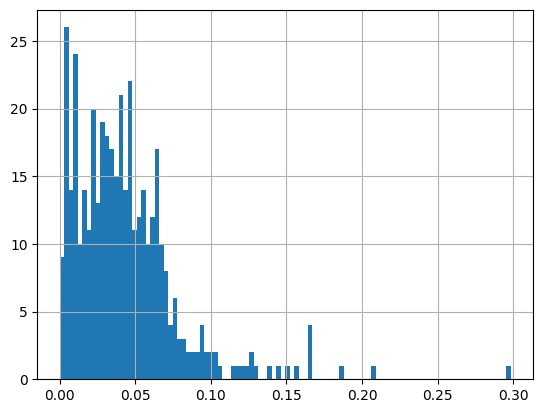

In [22]:
# ErrCube列の値が-1000または0である行を削除する
df_cube = df[(df['ErrCube'] != -1000.0) & (df['ErrCube'] != 0.0)]
df_cube['ErrCube'].hist(bins=100)

In [23]:
df_cube['ErrCube'].describe()

count    412.000000
mean       0.043292
std        0.034877
min        0.000145
25%        0.019631
50%        0.038085
75%        0.058892
max        0.298381
Name: ErrCube, dtype: float64

<Axes: >

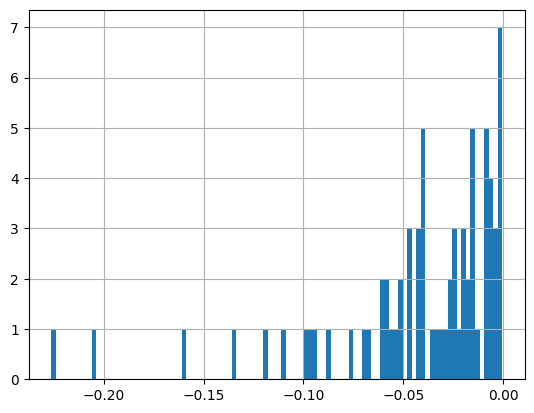

In [24]:
# ErrCube列の値が-1000または0である行を削除する
df_take = df[(df['ErrTake'] != -1000.0) & (df['ErrTake'] != 0.0)]
df_take['ErrTake'].hist(bins=100)

In [25]:
df_take['ErrTake'].describe()

count    72.000000
mean     -0.042028
std       0.045125
min      -0.226240
25%      -0.054821
50%      -0.028111
75%      -0.009351
max      -0.000659
Name: ErrTake, dtype: float64

In [26]:
# swap board if active player is a top player
df['Position'] = df.apply(lambda row: [-i for i in row['Position'][::-1]] if row['ActiveP'] == -1 else row['Position'], axis=1)    

In [27]:
df.to_pickle('data/xg_data.pkl')

In [28]:
df = pd.read_pickle('data/xg_data.pkl')

In [29]:
pd.crosstab(df['CubeB'], df['ActiveP'])

ActiveP,-1,1
CubeB,,
-3,3,0
-2,32,0
-1,329,0
0,1901,1808
1,0,337
2,0,18
3,0,1


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4429 entries, 5 to 41435
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    4429 non-null   object 
 1   EntryType               4429 non-null   int64  
 2   ActiveP                 4429 non-null   int64  
 3   Double                  4429 non-null   int64  
 4   Take                    4429 non-null   int64  
 5   BeaverR                 4429 non-null   int64  
 6   RaccoonR                4429 non-null   int64  
 7   CubeB                   4429 non-null   int64  
 8   Position                4429 non-null   object 
 9   Doubled_Pos             4429 non-null   object 
 10  Doubled_Level           4429 non-null   int64  
 11  Doubled_Score           4429 non-null   object 
 12  Doubled_Cube            4429 non-null   int64  
 13  Doubled_CubePos         4429 non-null   int64  
 14  Doubled_Jacoby          4429 non-null   int6